In [1]:
import requests
import io
import datetime

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from scipy import stats

In [3]:
INPUT_DIR = "input/"

In [4]:
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2021, 1, 1)

In [5]:
df = pd.read_csv(INPUT_DIR + 'weekly.csv')
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['power']

df_train = df[(df['ds'] < start)]
df_test = df[(df['ds']>= start) & (df['ds'] < end)]

In [6]:
def plot_prediction(orecast, data_test):
    output = pd.merge(forecast, data_test, on='ds', how='left').set_index('ds')

    cond = (output.index >= start) & (output.index < end)
    actual = output[cond]['y']
    pred = output[cond]['yhat']

    mape = (np.abs(pred - actual) / actual * 100).mean()

    actual.plot(label='actual')
    pred.plot(label=f'predict, MAPE:{mape:.2f} %')
    plt.legend()
    plt.show()
    
    (pred - actual).plot(label='residual')
    plt.legend()
    plt.show()

In [7]:
def correlation_plot(data, lags=60):
    fig = plt.figure(figsize=(10, 8))
    # 自己相関のコレログラム
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_ylim(-1.1, 1.1)
    fig = sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax1)
    # 偏自己相関のコレログラム
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_ylim(-1.1, 1.1)    
    fig = sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax2)
    plt.show()

## 原系列だけでProphet

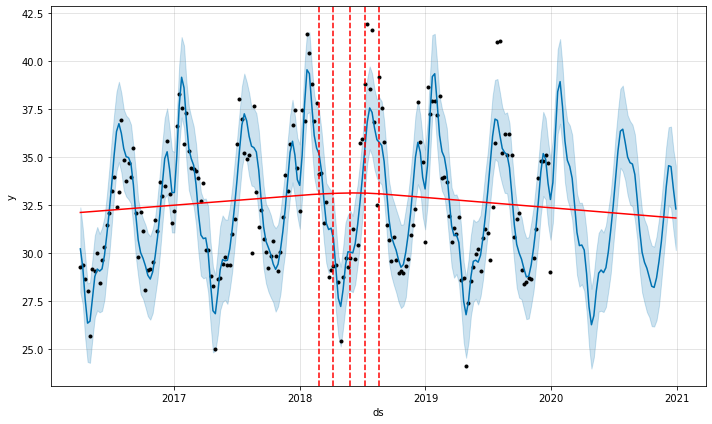

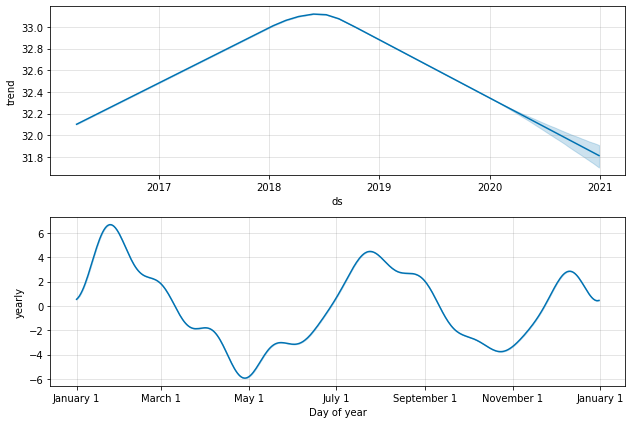

In [8]:
data_train = df_train[['ds', 'y']].copy()
data_test = df_test[['ds', 'y']].copy()

prophet = Prophet(daily_seasonality=False,
                  weekly_seasonality=False,
                  yearly_seasonality=True,
                  seasonality_mode='additive')
prophet.fit(data_train)
future = prophet.make_future_dataframe(periods=52, freq='W-MON')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
prophet.plot_components(forecast)
plt.show()

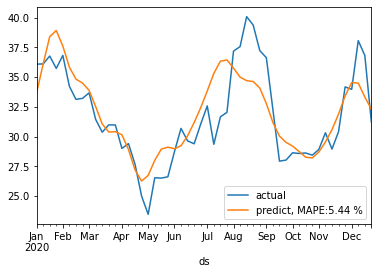

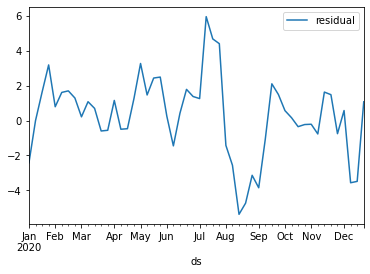

In [9]:
plot_prediction(forecast, data_test)

## 外部変数として気温を追加

In [10]:
df = pd.read_csv(INPUT_DIR + 'weekly.csv')
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['power']

df_temperature = pd.read_csv(INPUT_DIR + 'weekly_temperature.csv')
df_temperature['ds'] = pd.to_datetime(df_temperature['date'])

df = pd.merge(df[['ds', 'y']], df_temperature[['ds', 'temperature']], on='ds', how='left')
df

,ds,y,temperature
0,2016-04-04,29.249286,15.028571
1,2016-04-11,29.392024,14.685714
2,2016-04-18,28.636488,16.771429
3,2016-04-25,28.005298,17.114286
4,2016-05-02,25.686905,20.371429
...,...,...,...
254,2021-02-15,34.484524,9.271429
255,2021-02-22,33.862976,8.557143
256,2021-03-01,32.860893,NaN
257,2021-03-08,32.805179,NaN


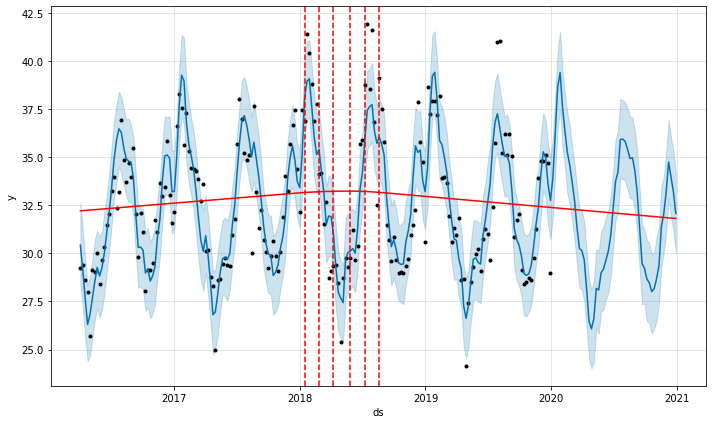

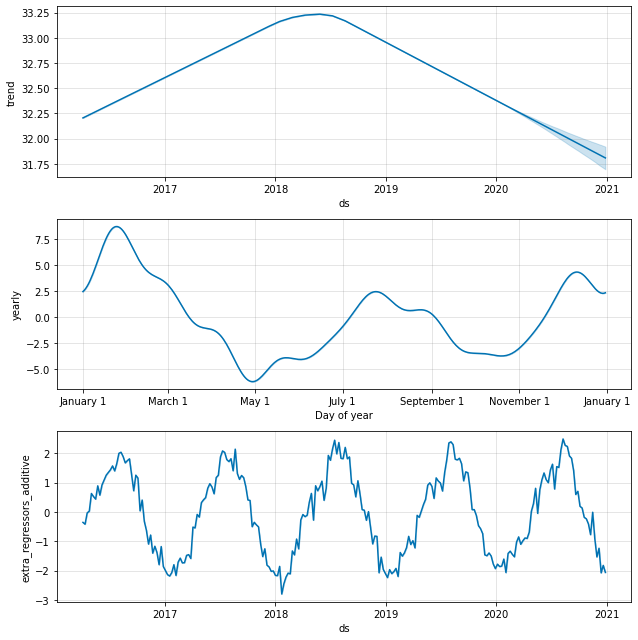

In [11]:
df_train = df[(df['ds'] < start)]
df_test = df[(df['ds']>= start) & (df['ds'] < end)]

data_train = df_train[['ds', 'y', 'temperature']].copy()
data_test = df_test[['ds', 'y', 'temperature']].copy()

prophet = Prophet(daily_seasonality=False,
                  weekly_seasonality=False,
                  yearly_seasonality=True,
                  seasonality_mode='additive')
prophet.add_regressor('temperature')
prophet.fit(data_train)
future = prophet.make_future_dataframe(periods=52, freq="W-MON")

future = pd.merge(future, df[['ds', 'temperature']], on='ds', how='left')  
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
prophet.plot_components(forecast)
# data_test.set_index('ds').plot()
plt.show()

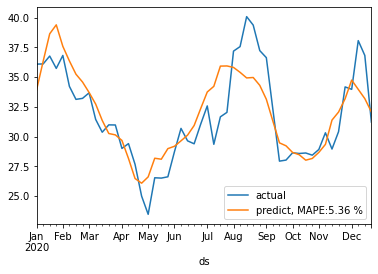

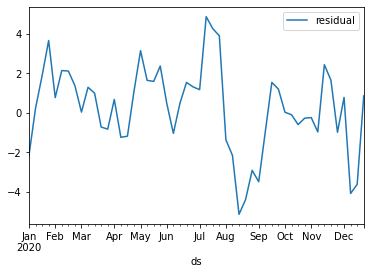

In [12]:
plot_prediction(forecast, data_test)

## 更にGDPを追加

In [13]:
df = pd.read_csv(INPUT_DIR + 'weekly.csv')
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['power']

df_temperature = pd.read_csv(INPUT_DIR + 'weekly_temperature.csv')
df_temperature['ds'] = pd.to_datetime(df_temperature['date'])

df_gdp = pd.read_csv(INPUT_DIR + 'weekly_gdp.csv')
df_gdp['ds'] = pd.to_datetime(df_gdp['date'])

df = pd.merge(df[['ds', 'y']], df_temperature[['ds', 'temperature']], on='ds', how='left')
df = pd.merge(df, df_gdp[['ds', 'gdp']], on='ds', how='left')
df

,ds,y,temperature,gdp
0,2016-04-04,29.249286,15.028571,134271.6
1,2016-04-11,29.392024,14.685714,134271.6
2,2016-04-18,28.636488,16.771429,134271.6
3,2016-04-25,28.005298,17.114286,134271.6
4,2016-05-02,25.686905,20.371429,134271.6
...,...,...,...,...
254,2021-02-15,34.484524,9.271429,NaN
255,2021-02-22,33.862976,8.557143,NaN
256,2021-03-01,32.860893,NaN,NaN
257,2021-03-08,32.805179,NaN,NaN


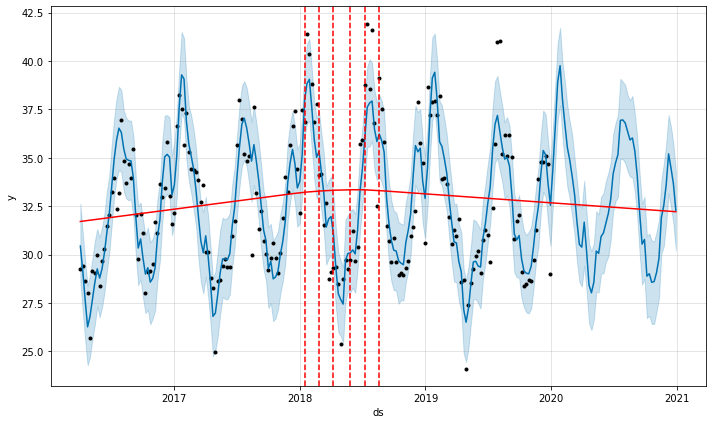

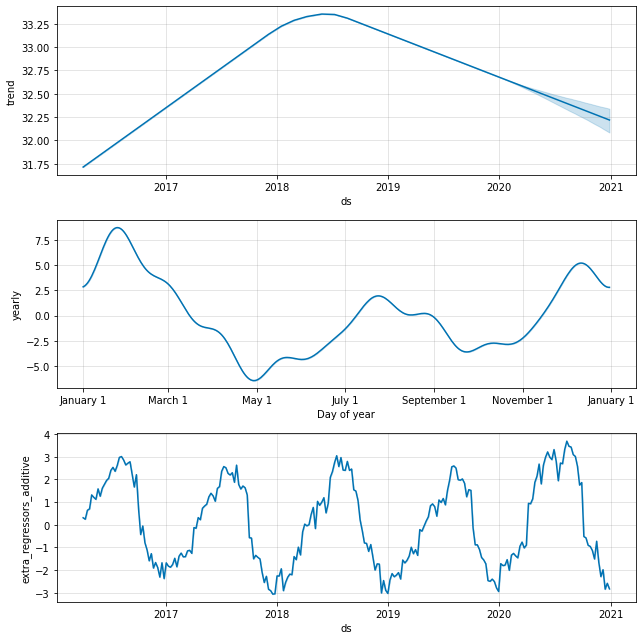

In [14]:
df_train = df[(df['ds'] < start)]
df_test = df[(df['ds']>= start) & (df['ds'] < end)]

data_train = df_train[['ds', 'y', 'temperature', 'gdp']].copy()
data_test = df_test[['ds', 'y', 'temperature', 'gdp']].copy()

prophet = Prophet(daily_seasonality=False,
                  weekly_seasonality=False,
                  yearly_seasonality=True,
                  seasonality_mode='additive')
prophet.add_regressor('temperature')
prophet.add_regressor('gdp')
prophet.fit(data_train)
future = prophet.make_future_dataframe(periods=52, freq='W-MON')

future = pd.merge(future, df[['ds', 'temperature', 'gdp']], on='ds', how='left')  
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
prophet.plot_components(forecast)
# data_test.set_index('ds').plot()
plt.show()

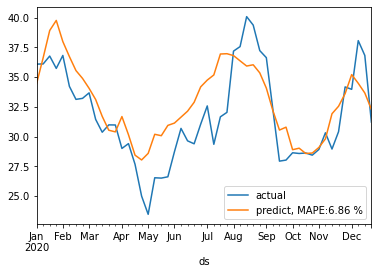

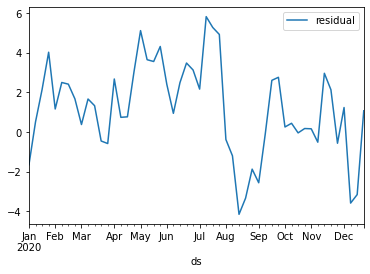

In [15]:
plot_prediction(forecast, data_test)

## 残差の確認

In [16]:
output = pd.merge(forecast, data_train, on='ds', how='left').set_index('ds')

cond = (output.index < start)
actual = output[cond]['y']
pred = output[cond]['yhat']

diff_arr = pred - actual

<AxesSubplot:>

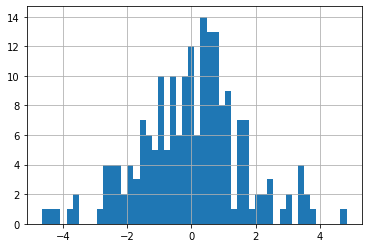

In [17]:
diff_arr.hist(bins=50)

In [18]:
jarque_bera_test = stats.jarque_bera(diff_arr)
print('Jack Bera:', '\t', jarque_bera_test)

Jack Bera: 	 Jarque_beraResult(statistic=1.8918504117319235, pvalue=0.38832012858748466)


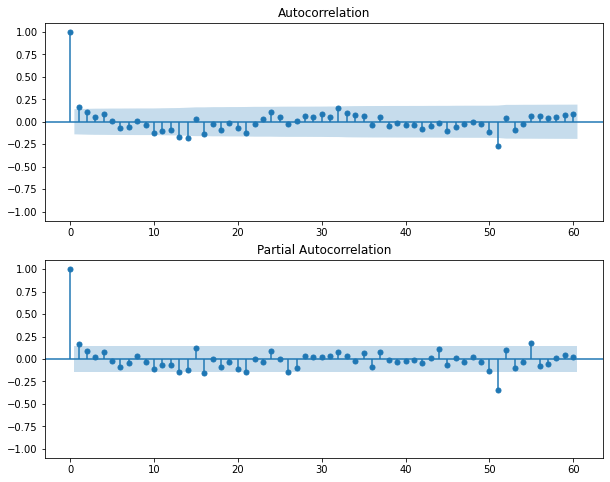

In [19]:
correlation_plot(diff_arr)

In [20]:
results = acorr_ljungbox(diff_arr, lags=10)
lag = 1
for lb, p in zip(results[0], results[1]):
    print(lag, lb, p)
    lag += 1

1 5.6267429364566155 0.01768846817382376
2 8.135394591293663 0.017116757995090767
3 8.771978531822892 0.03248132166754447
4 10.444579611234635 0.03356901430963565
5 10.46980928701333 0.0629666084222075
6 11.426664740727457 0.07605162176279412
7 12.060419390007738 0.09858936938429029
8 12.082797410957856 0.1475477238327534
9 12.40389587400262 0.19148514036645561
10 15.414330478395918 0.11767037801096608


/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


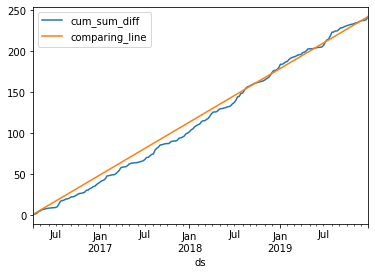

In [21]:
cum_arr = diff_arr.apply(np.abs).cumsum()

cum_min = cum_arr.min()
cum_max = cum_arr.max()

se_line = pd.Series(np.linspace(cum_min, cum_max, len(diff_arr)), index=diff_arr.index)

cum_arr.plot(label='cum_sum_diff')
se_line.plot(label='comparing_line')
plt.legend()
plt.show()